# Loading Libraries

In [ ]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone --filter=blob:none --quiet https://github.com/albu/albumentations /tmp/pip-req-build-4ywcqmi4
All libraries are successfully installed!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
from torchvision.models.segmentation import fcn_resnet50
import re
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Transformation for Data Augmentation

In [ ]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.2, rotate_limit=15, p=0.5),
    A.Resize(height=512, width=512),  # Ensure a consistent size
    ToTensorV2(transpose_mask=True)   # Converts image to tensor (default float32) and mask appropriately
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
val_transform = A.Compose([
    A.Resize(height=512, width=512),
    ToTensorV2(transpose_mask=True)
])

# Functions to Load Image and Mask

In [ ]:
def load_image(img_path):
    # Read image in BGR format then convert to RGB.
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def load_mask(img_path):
    # Map image path to mask path using the correct regex.
    mask_path = re.sub(r"(IMG_\d+)_part(\d+)(\.\w+)", r"\1_sunshad_part\2.tif", img_path)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Mask not found: {mask_path}")

    # Convert mask values: pixels with value 255 to 0 (background) and others to 1 (residue)
    mask = np.where(mask == 255, 0, 1).astype(np.uint8)
    return mask

# Custom Dataset Class

In [ ]:
class CropResidueDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask using the functions above.
        image = load_image(self.image_paths[idx])
        mask = load_mask(self.image_paths[idx])

        if self.transform:
            # Apply augmentation (or just resizing for validation)
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']   # Should already be a torch.Tensor
            mask = augmented['mask']
        else:
            # Fallback conversion if no transform is provided.
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask = torch.tensor(mask, dtype=torch.long)

        # --- IMPORTANT FIX ---
        # Force the image tensor to be float32 (if not already) to avoid type mismatches.
        image = image.float()

        # Ensure the mask is a LongTensor for CrossEntropyLoss.
        mask = mask.long()
        return image, mask

# Loading Dataset

In [ ]:
data_dir = "/content/drive/MyDrive/sunlit_shaded/Limbaugh1-1m20220328/IMG_0629"

image_paths = sorted(glob(os.path.join(data_dir, "IMG_*_part*.jpg"), recursive=True))
#image_paths = sorted(glob(os.path.join(data_dir, "**", "IMG_*_part*.jpg"), recursive=True))

# Train Test Split

In [ ]:
train_images, val_images = train_test_split(image_paths, test_size=0.2, random_state=42)

In [ ]:
train_dataset = CropResidueDataset(train_images, transform=train_transform)
val_dataset   = CropResidueDataset(val_images, transform=val_transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model 1

In [ ]:
model = fcn_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(512, 2, kernel_size=1)
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:00<00:00, 193MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Performance Metrics

## 1. IOU

In [ ]:
def calculate_iou(pred, target):
    # Flatten tensors.
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    iou = intersection.float() / (union.float() + 1e-6)
    return iou

# Training

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3):
    epoch_iou = []  # Store IoU for each epoch

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        all_preds = []
        all_targets = []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Collect predictions and targets for IoU calculation.
            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

        # Concatenate predictions and targets across batches.
        all_preds = np.concatenate(all_preds, axis=0)
        all_targets = np.concatenate(all_targets, axis=0)
        iou = calculate_iou(torch.tensor(all_preds), torch.tensor(all_targets))
        epoch_iou.append(iou.item())

        # Plot IoU vs. Epochs.
        plt.plot(range(1, epoch + 2), epoch_iou, marker='o', linestyle='-')
        plt.xlabel("Epochs")
        plt.ylabel("IoU Score")
        plt.title("IoU vs. Epochs")
        plt.grid(True)
        plt.pause(0.1)

        print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, IoU: {iou.item():.4f}")

    plt.show()

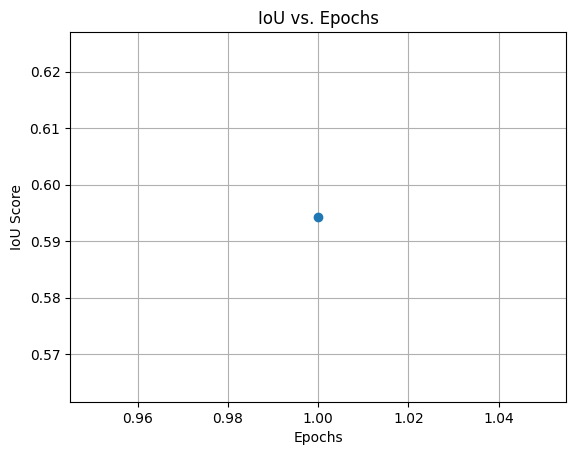

Epoch 1, Loss: 0.6402, IoU: 0.5943


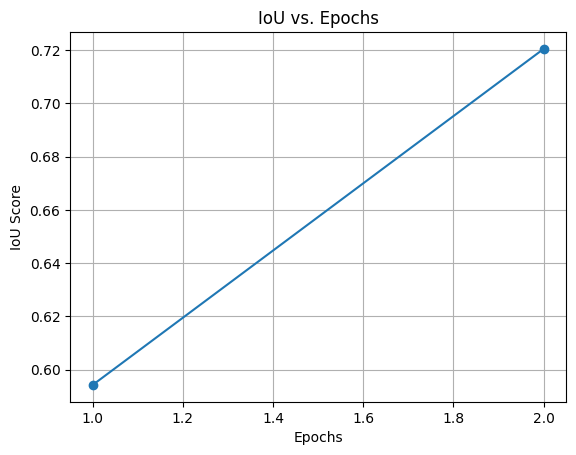

Epoch 2, Loss: 0.5173, IoU: 0.7204


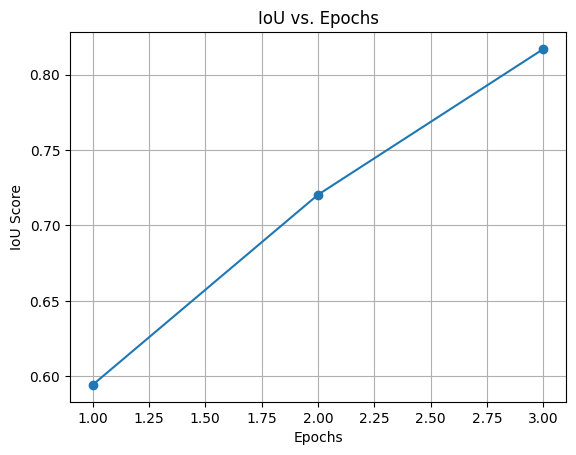

Epoch 3, Loss: 0.4311, IoU: 0.8170


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

# Save Model

In [ ]:
model_path = "/content/sunlit_model.pth"
torch.save(model.state_dict(), model_path)